In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib
import matplotlib.pyplot as plt
import analysis_pca

Ts = 1000
data_path = r'C:\Users\IBS\Desktop\python_code_N2'
save_path = r'C:\Users\IBS\Desktop\figures'

import pre_processing

ppss = pre_processing.pre_processing(Ts, data_path, save_path)
[final_cat, data_cat, val_cat, dur_cat, rejectedXY_cat] = ppss.datasorting_orientation(1)

val_cat = np.array(val_cat)[:,:8]
data_cat = np.array(data_cat)[:, :8]

In [2]:
import preprecessing_distMat

pdm = preprecessing_distMat.preprecessing_distMat(Ts, data_cat, val_cat, save_path)
onset_delay = pdm.peak_delay(win=20)
p_t = pdm.peak_MDS(onset_delay)

C:\Users\IBS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


(np.float64(-3.9303680645268777),
 np.float64(3.9764012121264503),
 np.float64(-4.608530487613892),
 np.float64(5.543546924808359))

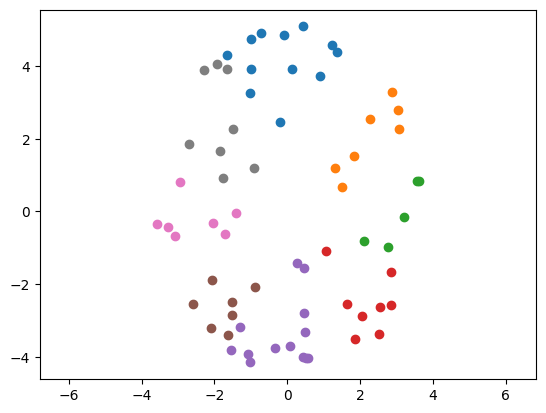

In [3]:
#Sorting cell by degree

from scipy.spatial import distance
from math import degrees

sp1 = np.argsort(p_t[:,1])[::-1][:5]
sp2 = np.argsort(np.abs(p_t[sp1, :][:, 0]))
sp = sp1[sp2[0]]

# p = p_t[sp]
cent = np.mean(p_t, axis=0)
p = [cent[0], cent[1] + 6]

deg_f = []
for a in range(len(p_t)):
    q = p_t[a]
    cos = 1-distance.cosine(p, q)
    deg = degrees(np.arccos(cos))
    if q[0] - p[0] < 0:
        deg = 360 - deg

    deg_f.append(deg)
deg_f = np.array(deg_f)

deg_idx = np.linspace(0, 360, 9) + 22.5
deg_idx = np.append(deg_idx[7], deg_idx[:7])

C_cat = []
for a in range(len(deg_idx)):
    if a == 0:
        C = np.where(np.logical_or(deg_f > deg_idx[a], deg_f <= deg_idx[a+1]))
    elif a == 7:
        C = np.where(np.logical_and(deg_f > deg_idx[a], deg_f <= deg_idx[0]))
    else:
        C = np.where(np.logical_and(deg_f > deg_idx[a], deg_f <= deg_idx[a+1]))
    C_cat.append(C)

# plotting
for a in range(8):
    plt.scatter(p_t[[C_cat[a]],0], p_t[[C_cat[a]],1])
plt.axis('equal')

# plt.savefig('pizza_plot.jpg', dpi=300)

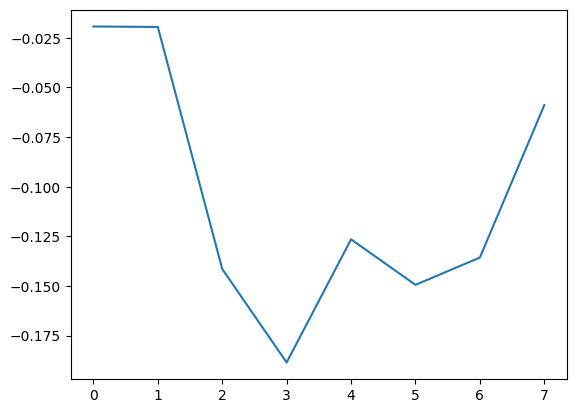

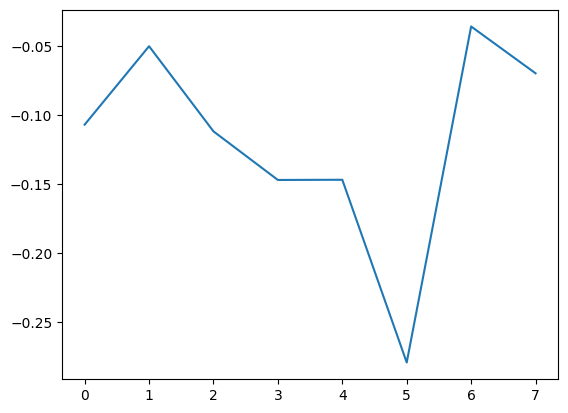

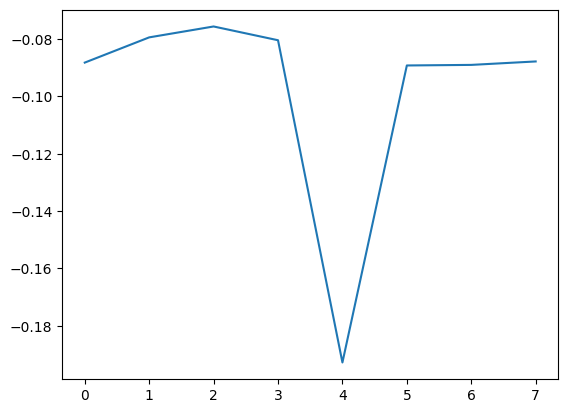

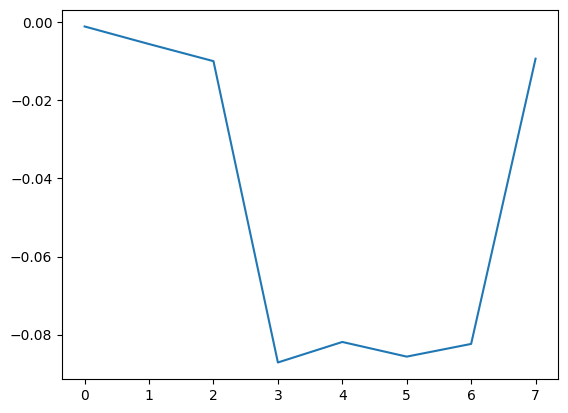

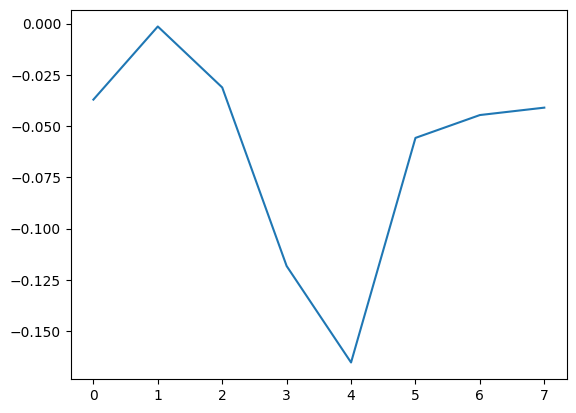

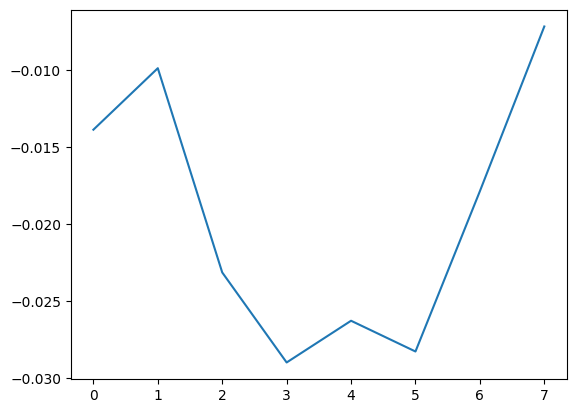

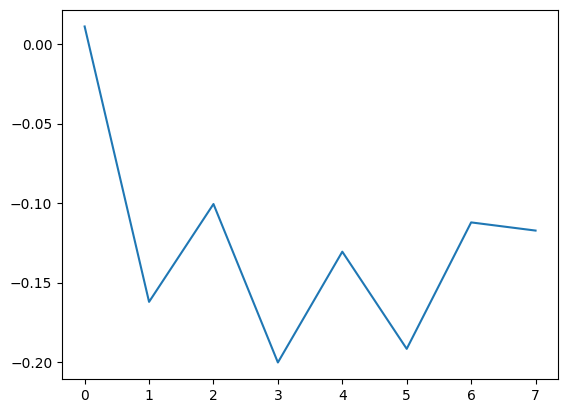

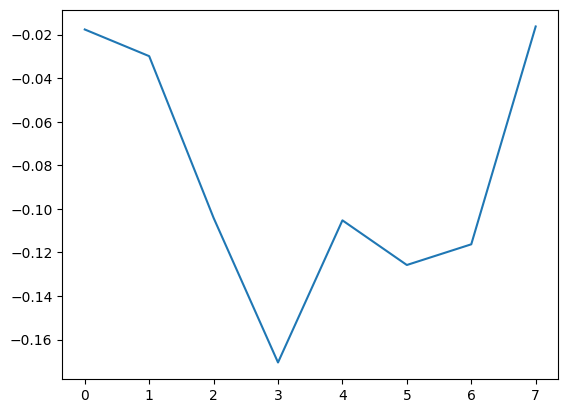

In [4]:
# Aligned data by latency

onset_delay_M = onset_delay[C_cat[0]]
for a in range(1,8):
    temp = onset_delay[C_cat[a]]
    temp2 = np.concat([temp[:,a:8], temp[:,:a]], axis=1)
    onset_delay_M = np.vstack([onset_delay_M, temp2])

idx_c =[0]
for a in range(8):
    idx_c.append(len(C_cat[a][0]))
idx_c = np.cumsum(idx_c)  

for a in range(8):
    plt.figure()
    plt.plot(np.mean(onset_delay_M[idx_c[a]:idx_c[a+1]], axis=0))

# Data align

data_cat2 = data_cat[C_cat[0]]
for a in range(1,8):
    temp = data_cat[C_cat[a]]
    temp2 = np.concat([temp[:,a:8], temp[:,:a]], axis=1)
    data_cat2 = np.vstack([data_cat2, temp2])

data_cat2 = np.hstack([data_cat2, data_cat2])  # put dummy for using analysis_pca code
data_cat2 = data_cat2[:,:9]

In [5]:
#For FN angle aligned PCA

apca = analysis_pca.analysis_pca(Ts, data_cat2, save_path)
data_cat_sm = apca.smoothing_data()  # Smoothed data

In [6]:
import multiprocessing as mp
import parmap
import generate_data
from functools import partial
import generate_data as gend

irt=10000

num_cores = 20
irt_input=list(range(0,irt))
splited_irt =  np.array_split(irt_input, num_cores)
input_data = data_cat_sm
ggd = gend.generate_data(input_data, Ts)

test_out = parmap.map(ggd.generate_data2, splited_irt, pm_pbar=True, pm_processes=num_cores)

test_out=np.concatenate(test_out,axis=0)

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
np.shape(test_out)

(10000, 8, 4, 600)

In [21]:
import random



list__ = np.arange(67)
clist = [random.choice(list__) for i in range(len(list__))]
clist = np.array(clist)

data_new = data_cat_sm[:, clist, :]
data = np.mean(data_new, axis=0)  # Anagle averged data
PCA_total = apca.pca_analy(data)  # PCA

Wa = PCA_total['v'][:4]  # Wight matrix from angle averaged PCA

In [ ]:
import multiprocessing as mp
import parmap
import generate_data
from functools import partial

irt=10000

num_cores = 20
irt_input=list(range(0,irt))
splited_irt =  np.array_split(irt_input, num_cores)
input_data = [Wa, data_cat_sm]
func=partial(generate_data.generate_data, input_data)

test_out = parmap.map(func, splited_irt, pm_pbar=True, pm_processes=num_cores)

test_out=np.concatenate(test_out,axis=0)

In [5]:
#For FN angle aligned PCA

apca = analysis_pca.analysis_pca(Ts, data_cat2, save_path)
data_cat_sm = apca.smoothing_data()  # Smoothed data
data = np.mean(data_cat_sm, axis=0)  # Anagle averged data
PCA_total = apca.pca_analy(data)  # PCA

Wa = PCA_total['v'][:4]  # Wight matrix from angle averaged PCA

Dimensions: 1, Variance explained: 75.06%
Dimensions: 2, Variance explained: 85.13%
Dimensions: 3, Variance explained: 90.34%
Dimensions: 4, Variance explained: 93.95%
Dimensions: 5, Variance explained: 96.15%
Dimensions to be reduced: 3


In [6]:
#For FN angle original PCA

data_cat = np.hstack([data_cat, data_cat])  # put dummy for using analysis_pca code
data_cat = data_cat[:,:9]
apca = analysis_pca.analysis_pca(Ts, data_cat, save_path)
data_cat_sm2 = apca.smoothing_data()  # Smoothed data
data2 = np.mean(data_cat_sm2, axis=0)  # Anagle averged data
PCA_total2 = apca.pca_analy(data2)  # PCA

Wa2 = PCA_total2['v'][:4]  # Wight matrix from angle averaged PCA

Dimensions: 1, Variance explained: 75.06%
Dimensions: 2, Variance explained: 85.13%
Dimensions: 3, Variance explained: 90.34%
Dimensions: 4, Variance explained: 93.95%
Dimensions: 5, Variance explained: 96.15%
Dimensions to be reduced: 3


In [8]:
#Multiply weight matrix (MWM) to each angle data

final_out = []
for a in range(8):
    out = Wa @ data_cat_sm[a]
    final_out.append(out)

final_out = np.array(final_out)

In [9]:
#Multiply weight matrix (MWM) to each angle data2 (original)

final_out2 = []
for a in range(8):
    out = Wa2 @ data_cat_sm2[a]
    final_out2.append(out)

final_out2 = np.array(final_out2)

In [17]:
import multiprocessing as mp
import parmap
import generate_data
from functools import partial

irt=10000

num_cores = 20
irt_input=list(range(0,irt))
splited_irt =  np.array_split(irt_input, num_cores)
input_data = [Wa, data_cat_sm]
func=partial(generate_data.generate_data, input_data)

test_out = parmap.map(func, splited_irt, pm_pbar=True, pm_processes=num_cores)

test_out=np.concatenate(test_out,axis=0)

  0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
sTemplet2= np.mean(test_out[:, :, :, :100], axis=3)
sTemplet2 = np.repeat(sTemplet2[np.newaxis, :], 600, axis=0)
sTemplet2 = np.transpose(sTemplet2, [1,2,3,0])
nfinal_out2 = test_out - sTemplet2

In [9]:
nfinal_out2.shape

(10000, 8, 4, 600)

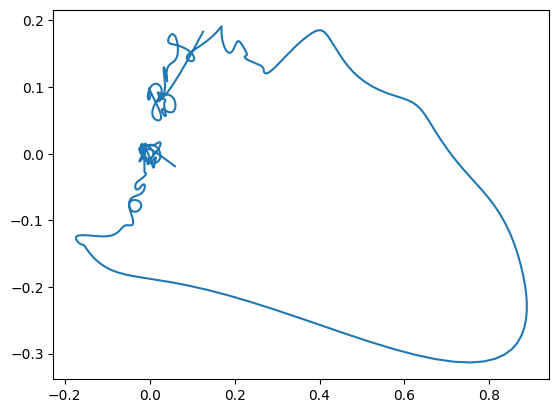

In [10]:
# for a in range(100):
a=20
plt.plot(nfinal_out2[a,0,0,:],nfinal_out2[a,0,1,:])

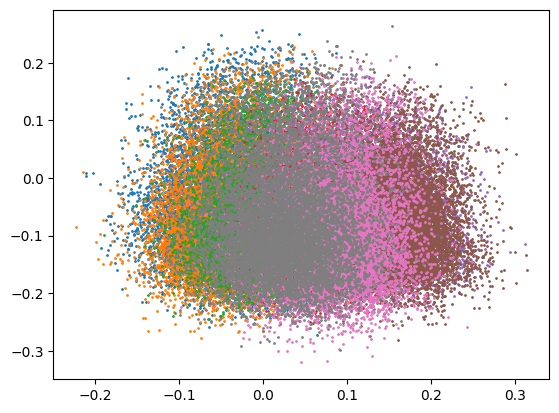

In [29]:
a = 280

plt.scatter(nfinal_out2[:,0,0,a], nfinal_out2[:,0,1,a],1)
plt.scatter(nfinal_out2[:,1,0,a], nfinal_out2[:,1,1,a],1)
plt.scatter(nfinal_out2[:,2,0,a], nfinal_out2[:,2,1,a],1)
plt.scatter(nfinal_out2[:,3,0,a], nfinal_out2[:,3,1,a],1)
plt.scatter(nfinal_out2[:,4,0,a], nfinal_out2[:,4,1,a],1)
plt.scatter(nfinal_out2[:,5,0,a], nfinal_out2[:,5,1,a],1)
plt.scatter(nfinal_out2[:,6,0,a], nfinal_out2[:,6,1,a],1)
plt.scatter(nfinal_out2[:,7,0,a], nfinal_out2[:,7,1,a],1)

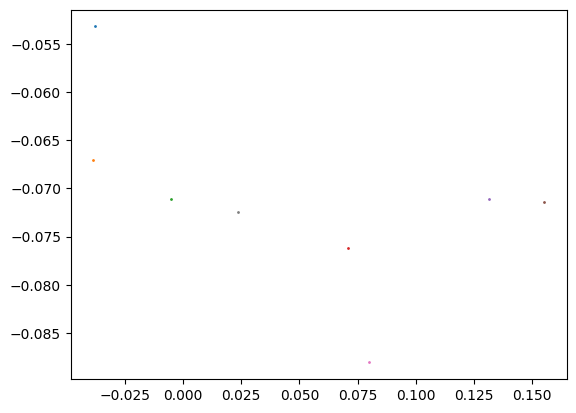

In [30]:
nfinal_out2_m = np.mean(nfinal_out2, axis=0)
plt.scatter(nfinal_out2_m[0,0,a], nfinal_out2_m[0,1,a],1)
plt.scatter(nfinal_out2_m[1,0,a], nfinal_out2_m[1,1,a],1)
plt.scatter(nfinal_out2_m[2,0,a], nfinal_out2_m[2,1,a],1)
plt.scatter(nfinal_out2_m[3,0,a], nfinal_out2_m[3,1,a],1)
plt.scatter(nfinal_out2_m[4,0,a], nfinal_out2_m[4,1,a],1)
plt.scatter(nfinal_out2_m[5,0,a], nfinal_out2_m[5,1,a],1)
plt.scatter(nfinal_out2_m[6,0,a], nfinal_out2_m[6,1,a],1)
plt.scatter(nfinal_out2_m[7,0,a], nfinal_out2_m[7,1,a],1)

In [11]:
#Adjust MWM by subtract data point at -300 to -200ms

tmep_final = np.transpose(final_out,[2,0,1])
sTemplet = np.mean(tmep_final[:100], axis=0)
sTemplet = np.repeat(sTemplet[np.newaxis, :, :], 600, axis=0)
nfinal_out = np.transpose(tmep_final - sTemplet, [1, 2, 0])


#Adjust PCA by subtract data point at -300 to -200ms

tmep_final = PCA_total['p']
sTemplet = np.mean(tmep_final[:100], axis=0)
sTemplet = np.repeat(sTemplet[np.newaxis, :], 600, axis=0)
nPCA_out = tmep_final.T - sTemplet.T

NameError: name 'final_out' is not defined

In [10]:
#Adjust MWM by subtract data point at -300 to -200ms (original)

tmep_final2 = np.transpose(final_out2,[2,0,1])
sTemplet2 = np.mean(tmep_final2[:100], axis=0)
sTemplet2 = np.repeat(sTemplet2[np.newaxis, :, :], 600, axis=0)
nfinal_out2 = np.transpose(tmep_final2 - sTemplet2, [1, 2, 0])


#Adjust PCA by subtract data point at -300 to -200ms (original)

tmep_final2 = PCA_total2['p']
sTemplet2 = np.mean(tmep_final2[:100], axis=0)
sTemplet2 = np.repeat(sTemplet2[np.newaxis, :], 600, axis=0)
nPCA_out2 = tmep_final2.T - sTemplet2.T

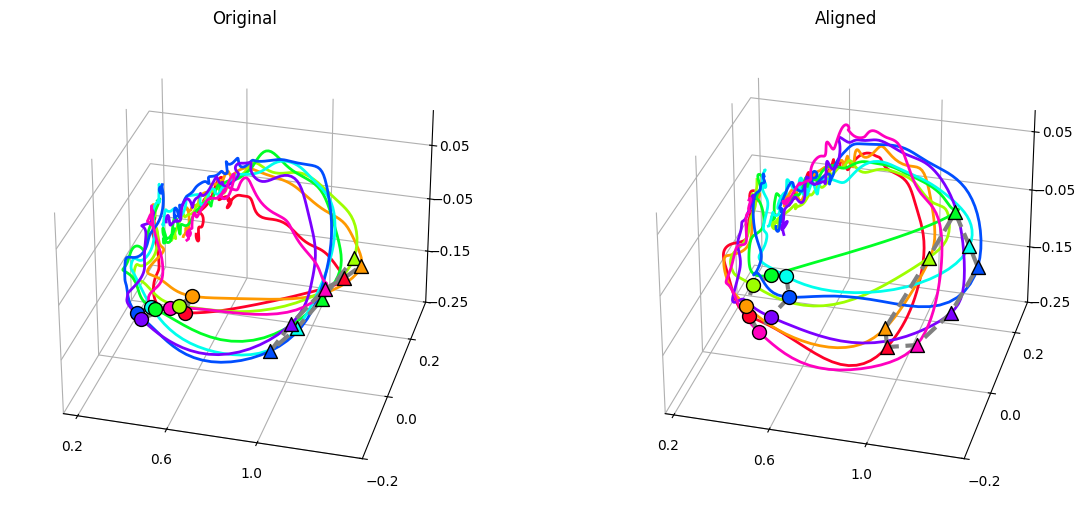

In [12]:
# Pretty figure

from matplotlib.markers import CARETUP
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# color map
cmap = matplotlib.colormaps.get_cmap("gist_rainbow")
C_list = cmap( np.linspace(0.0, 1.0, 8) ) # extract 20 colors from cmap

fig = plt.figure(constrained_layout=True,figsize=(12,5))
# subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1, 1])

# 3D plot of angle original data

# subfigs[0].subplots(1, 1)
ax = fig.add_subplot(1, 2, 1, projection='3d')
for a in range(8):
    X = final_out2[a, 0]; Y = final_out2[a, 1]; Z = final_out2[a, 2]
    ax.plot(X[200:500], Y[200:500], Z[200:500], label='parametric curve', color = C_list[a], linewidth = 2)
    
    ax.scatter(X[280], Y[280], Z[280], s=100, color = C_list[a], facecolors=C_list[a], edgecolors='black')
    ax.scatter(X[300], Y[300], Z[300], marker='^', s=100, color = C_list[a], facecolors = C_list[a], edgecolors='black')
X = final_out2[:, 0]; Y = final_out2[:, 1]; Z = final_out2[:, 2]
ax.plot(np.hstack([X[:, 280], X[0, 280]]),
        np.hstack([Y[:, 280], Y[0, 280]]),
        np.hstack([Z[:, 280], Z[0, 280]]),
        ls = '--', color = [0.5, 0.5, 0.5], linewidth = 3)
ax.plot(np.hstack([X[:, 300], X[0, 300]]),
        np.hstack([Y[:, 300], Y[0, 300]]),
        np.hstack([Z[:, 300], Z[0, 300]]),
        ls = '--', color = [0.5, 0.5, 0.5], linewidth = 3)


ax.set_title("Original")
# ax.set_xlabel('1D'); ax.set_ylabel('2D'); ax.set_zlabel('3D')


# 3D plot of angle aligned data

# subfigs[0].subplots(1, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
for a in range(8):
    X = final_out[a, 0]; Y = final_out[a, 1]; Z = final_out[a, 2]
    ax2.plot(X[200:500], Y[200:500], Z[200:500], label='parametric curve', color = C_list[a], linewidth = 2)
    ax2.scatter(X[280], Y[280], Z[280], s=100, color = C_list[a], facecolors=C_list[a], edgecolors='black')
    ax2.scatter(X[300], Y[300], Z[300], marker='^', s=100, color = C_list[a], facecolors = C_list[a], edgecolors='black')
X = final_out[:, 0]; Y = final_out[:, 1]; Z = final_out[:, 2]
ax2.plot(np.hstack([X[:, 280], X[0, 280]]),
        np.hstack([Y[:, 280], Y[0, 280]]),
        np.hstack([Z[:, 280], Z[0, 280]]),
        ls = '--', color = [0.5, 0.5, 0.5], linewidth = 3)
ax2.plot(np.hstack([X[:, 300], X[0, 300]]),
        np.hstack([Y[:, 300], Y[0, 300]]),
        np.hstack([Z[:, 300], Z[0, 300]]),
        ls = '--', color = [0.5, 0.5, 0.5], linewidth = 3)


ax2.set_title("Aligned")
# ax2.set_xlabel('1D'); ax2.set_ylabel('2D'); ax2.set_zlabel('3D')
# ax.set_axis_off()
ax.set_xticks(np.arange(0.2 , 1.4, 0.4))
ax.set_yticks(np.arange(-0.2 , 0.3, 0.2))
ax.set_zticks(np.arange(-0.25 , 0.1, 0.1))
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.grid(False)

# ax2.set_axis_off()
ax2.set_xticks(np.arange(0.2 , 1.4, 0.4))
ax2.set_yticks(np.arange(-0.2 , 0.3, 0.2))
ax2.set_zticks(np.arange(-0.25 , 0.1, 0.1))
ax2.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax2.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax2.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax2.grid(False)

# animation
def run(frame_number):
    ax.view_init(azim=225 + frame_number*2)
    ax2.view_init(azim=225 + frame_number*2)

# rotation figure
run(30)
# plt.legend(loc='lower right', bbox_to_anchor=(1, 1))
plt.savefig('3d plot.jpg', dpi=300)
plt.show()

# make animation
# anim = FuncAnimation(fig, run, frames=180, interval=20)
# HTML(anim.to_jshtml())
# anim.save('scatter.gif', writer='imagemagick', fps=25, dpi=80)




In [13]:
import roundness

X = final_out2[:, 0]; Y = final_out2[:, 1]; Z = final_out2[:, 2]
r_data = np.array([X[:, 280], Y[:, 280], Z[:, 280]]).T
r1 = roundness.roundness(r_data)

r_data = np.array([X[:, 300], Y[:, 300], Z[:, 300]]).T
r2 = roundness.roundness(r_data)

X = final_out[:, 0]; Y = final_out[:, 1]; Z = final_out[:, 2]
r_data = np.array([X[:, 280], Y[:, 280], Z[:, 280]]).T
r3 = roundness.roundness(r_data)

X = final_out[:, 0]; Y = final_out[:, 1]; Z = final_out[:, 2]
r_data = np.array([X[:, 300], Y[:, 300], Z[:, 300]]).T
r4 = roundness.roundness(r_data)

rr = np.round([r1, r2, r3, r4], 2)

In [14]:
rr

array([0.65, 0.56, 0.82, 0.79])

In [16]:
r_data

array([[ 1.03997917, -0.13271672, -0.1198018 ],
       [ 1.0331843 , -0.13466222, -0.08752004],
       [ 1.14917345, -0.04077713, -0.0121905 ],
       [ 1.20980654,  0.03772176,  0.02804814],
       [ 1.28563027,  0.01062028, -0.0106548 ],
       [ 1.31496161,  0.02376706, -0.05012959],
       [ 1.2460216 , -0.0446867 , -0.09662191],
       [ 1.14507197, -0.10881565, -0.12301723]])